# DATA512_A2_Bias_in_data
Jiyu Wang

In this assignment, we are trying to identify potential sources of bias in the Wikipedia Talk corpus and describe some implications of the biases.

First, let's import some libraries necessary for our analysis.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
%matplotlib inline

## Wikipedia Talk Corpus
The corpus contains three datasets, each of which contains thousands of online discussion posts discussing how to write and edit Wikipedia articles. Crowdworkers have labelled these posts for three kinds of hostile speech: 'toxicity', 'aggression', and 'personal attacks'.

These datasets have been used to train machine learning models and used in a variety of softwares. The data is publicaly available through the Perspective API.

In this assignment, I selected two datasets: the aggression dataset and the toxicity dataset to identify potential sources of biases.

* Define a function to create file paths for the raw data of a specific dataset

In [2]:
"""
path_creater
input:
    topic - one of aggression, toxicity
output:
    a dictionary with three items:
        comments: path to the annotated comments file
        annotations: path to the annotations file
        workers: path to the worker demographics file
"""
def path_creater(topic):
    topic_dir = f'raw_data/{topic}/'
    return {'comments': topic_dir+topic+'_annotated_comments.tsv',
            'annotations': topic_dir+topic+'_annotations.tsv',
            'workers': topic_dir+topic+'_worker_demographics.tsv'}

* import dataset raw file and create processed file for analysis

Our analysis will require two files from each dataset: the annotation file and the worker demographics file

So import these two files for both dataset:

In [3]:
# aggression dataset
agg_files = path_creater('aggression')
anno_agg = pd.read_csv(agg_files['annotations'], sep='\t')
worker_agg = pd.read_csv(agg_files['workers'], sep='\t')

# toxicity dataset
tox_files = path_creater('toxicity')
anno_tox = pd.read_csv(tox_files['annotations'], sep='\t')
worker_tox = pd.read_csv(tox_files['workers'], sep='\t')

To facilitate our analysis, I joined the annotation file and demographics data to create a finalized file to analyze contents in both files. This joined dataframe is stored in our csv directory.

In [4]:
csv_dir = 'csv/'
if not os.path.exists(csv_dir):
    os.mkdir(csv_dir)

# aggression join and save
anno_worker_agg = anno_agg.merge(worker_agg, on='worker_id')
anno_worker_agg.to_csv(csv_dir+'aggression_joined.csv', index=False)

# toxicity join and save
anno_worker_tox = anno_tox.merge(worker_tox, on='worker_id')
anno_worker_tox.to_csv(csv_dir+'toxicity_joined.csv', index=False)

## Identify potential biases

Load joined datasets created above before analysis.

In [5]:
csv_dir = 'csv/'

# aggression
anno_worker_agg = pd.read_csv(csv_dir+'aggression_joined.csv')

# toxicity
anno_worker_tox = pd.read_csv(csv_dir+'toxicity_joined.csv')

Some info on these two files:

In [6]:
anno_worker_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855514 entries, 0 to 855513
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   rev_id                  855514 non-null  int64  
 1   worker_id               855514 non-null  int64  
 2   aggression              855514 non-null  float64
 3   aggression_score        855514 non-null  float64
 4   gender                  855514 non-null  object 
 5   english_first_language  855514 non-null  int64  
 6   age_group               843507 non-null  object 
 7   education               855514 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 52.2+ MB


In [7]:
anno_worker_tox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346955 entries, 0 to 1346954
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   rev_id                  1346955 non-null  float64
 1   worker_id               1346955 non-null  int64  
 2   toxicity                1346955 non-null  int64  
 3   toxicity_score          1346955 non-null  float64
 4   gender                  1346955 non-null  object 
 5   english_first_language  1346955 non-null  int64  
 6   age_group               1317641 non-null  object 
 7   education               1346955 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 82.2+ MB


### How consistent are labelling behaviors among workers with different demographic profiles?

Four variables were provided demonstrating the demographic information of the annotators. Since personal opinions on whether a comment is toxic or aggressive highly depend on personal experience and demographic situations, we would like to ask this question on how workers with different background label comments differently. The information will be useful in determining the applicability and objectivity of the dataset.

To answer this question, I would like to describe the distribution of labelled scores in each category and assess if there is bias in the distribution.

Define a function to plot bar graph of contingency table with two variables from one dataset:

In [8]:
"""
create_hist
input:
    data - the dataset to analyze
    ax - the plot ax
    indvar - variable 1 (demographic info)
    depvar - variable 2 (score)
output:
    bar graph of contingency table of two variables
"""
def create_hist(data, ax, indvar, depvar):
    # create contingency table
    df = pd.crosstab(index=data[indvar], columns=data[depvar])
    nr, nc = df.shape
    
    # necessary items for plot
    labels = list(df.columns)
    legendlabels = list(df.index)
    x = np.arange(len(labels))

    width = 1/(nr+1)
    pos = []
    if nr%2 == 0:
        c = nr//2
        pos = [2*i+1 for i in range(-c, c)]
    else:
        c = nr//2
        pos = [2*i for i in range(-c, c+1)]

    colors = 'krybmgc'
    
    df.iloc[:,:] = Normalizer(norm='l1').fit_transform(df)
    
    # plot each pair
    for i in range(nr):
        ax.bar(x + width*pos[i]/2, df.iloc[i], width, color=colors[i])

    ax.set_ylabel('count ratio')
    ax.set_xlabel(depvar)
    ax.set_title(f'count by {indvar}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(legendlabels, loc='upper left')

1. labelling behaviors in the aggression dataset

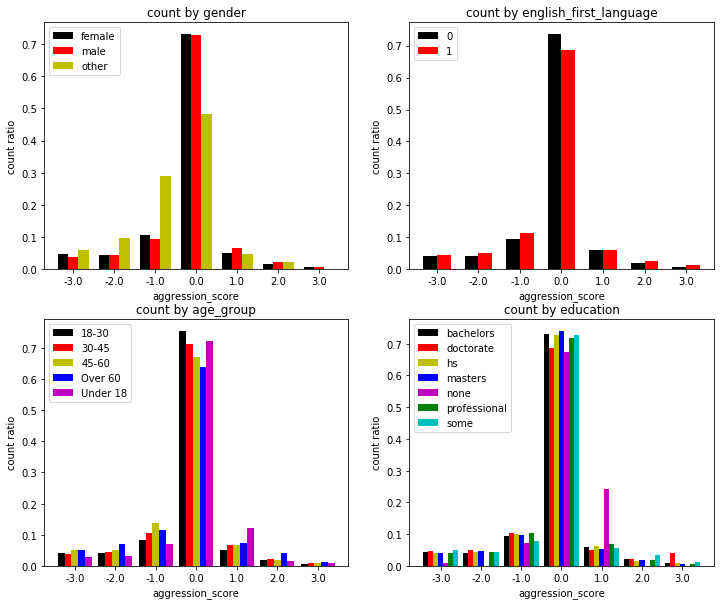

In [9]:
cols = ['gender', 'english_first_language', 'age_group', 'education']

fig, axe = plt.subplots(2,2,figsize = (12, 10))
for i in range(2):
    for j in range(2):
        idx = 2*i+j
        create_hist(anno_worker_agg, axe[i][j], cols[idx], 'aggression_score')
fig.savefig('aggression_score_demo.png', dpi=200)

Our discoveries are:
- the ratio of comments labeled as aggressive by females is approximately same as that by males, while there are slight differences indicating that females are more likely to label comments as aggressive than males.

- the situation on whether the annotator is native english speaker is similar to that on the gender. Non-native English speakers are slightly more likely to label comments as aggressive than native English speakers.

- There are obvious trends on the ratio of comments labeled by annotators of different age groups. Older annotators are more likely to label comments as aggressive than younger ones.

- Except for an abnormal peak for annotators with 'none' education degrees, there are few difference among the ratios of aggressive comments for all education groups.

The differences in labelling behaviors among female vs male, native speakers vs non-native speakers, and different age groups may introduce biases in the labels. Besides, the 'none' education degree group may also cause biases in labeling.

2. labelling behaviors in the toxicity dataset

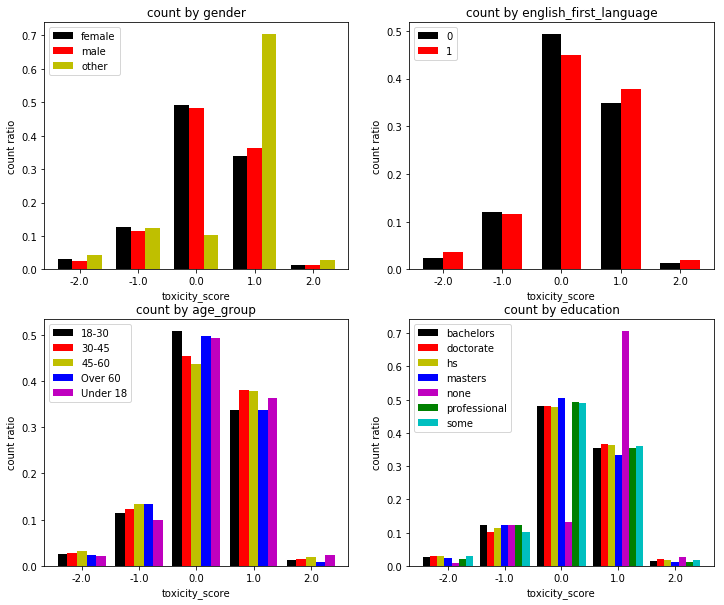

In [10]:
cols = ['gender', 'english_first_language', 'age_group', 'education']

fig, axe = plt.subplots(2,2,figsize = (12, 10))
for i in range(2):
    for j in range(2):
        idx = 2*i+j
        create_hist(anno_worker_tox, axe[i][j], cols[idx], 'toxicity_score')
fig.savefig('toxicity_score_demo.png', dpi=200)

The overall situation for toxicity dataset is similar to that of aggression dataset with two major differences:
- The non-native English speakers tend to label comments as not toxic compared to native speakers. This is opposite of what we observed in the aggression dataset.

- Most comments labeled by the 'none' education group have toxicity score of 1.0, which is significantly different from other groups.

The differences in gender and age groups as well as two major changes we described above will all introduce biases into the dataset.

### What is the level of disagreement around certain labels in different datasets?

Each comment was labeled by 10 different annotators. The agreement of these labels is critical for us to assess the reliability of the final output. So I would like to analyze the level of disagreement of labels in both datasets.

I will group annotations for each comment and use mean and variance as two metrics to assess the level of disagreement.

First define a function to calculate the metrics and make a scatter plot.

In [11]:
def assess_mean_var(data, ax, score):
    average = data[['rev_id', score]].groupby(by='rev_id').mean()
    variance = data[['rev_id', score]].groupby(by='rev_id').var()
    group = average.merge(variance, on='rev_id')
    group.columns = ['mean', 'variance']
    
    x=group['mean']
    y=group['variance']
    ax.plot(x, y, marker='.', c='k', linestyle='')
    ax.set_title(score)
    ax.set_xlabel('mean')
    ax.set_ylabel('variance')
    ax.set_ylim([0,14])

Create plots for both datasets:

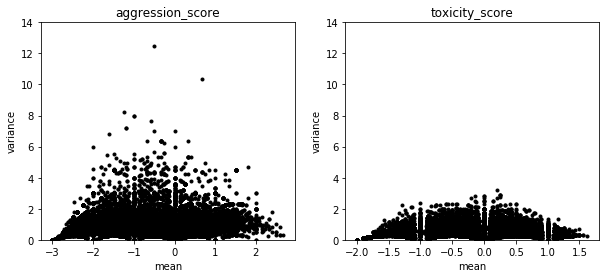

In [12]:
fig, axe = plt.subplots(1, 2, figsize=(10, 4))
assess_mean_var(anno_worker_agg, axe[0], 'aggression_score')
assess_mean_var(anno_worker_tox, axe[1], 'toxicity_score')
fig.savefig('comment_mean_var.png', dpi=200)

It is obvious that for both datasets, the variance of labels for comments with intermediate mean scores is larger than those with more extreme scores, while the variance of aggression score is larger than that of toxicity score.

So annotators tend to disagree more on aggressive comments than toxic comments. This level of disagreement will make the aggression dataset less reliable for further applications, since the aggression scores are less informative in this case.

## Discussions

1. Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?

I found two applications (Authorship Feedback and Author Perspective for Drupal) that would perform well.

These applications are designed to provide real-time feedback for authors based on the scores predicted by the model. The score output of the model is the average assessment by various people from different demographical groups, which can more-or-less acknowledge the author about possible influence of the content on other users. But the score is also only suggestive, so that the author still decides if he/she would consider modifying the comment based on his/her opinion on whether the score is appropriate or not.

2. Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?

I think that two applications (Comment Filter and Behave!) would perform poorly.

These applications either block the toxic comments or replace comments with emojis. They will perform poorly because they determine whether a comment is toxic or not for the user. Given the biases in the dataset and variances in personal opinions on the same comment, it is not appropriate or efficient to determine whether a comment is bad or not for other users.

3. Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

I would introduce more options that the user could specify the target clients to obtain certain subset of the dataset. For example, for a website with users of mostly young people, they can specifically pick data labeled by young age groups to increase the accuracy and efficiency of predictions. Even for websites that have users from different groups, they can provide more accurate predictions by selecting subset of dataset based on the user's information. These new options will allow users to avoid the biases introduced by the annotataions from different demographic groups.